In [1]:
from gilfordpaper.functions import *
from gilfordpaper.simulate_ecosystem import *
import matplotlib.pyplot as plt
import numpy as np

In [28]:
# Define hyperparameters
Total_Number_Of_Species = 1000
numSpecies = 100
numGroups = 4
numResource = 4
Total = 100
specialist = 0.5
specialistVariation = 0.01

# Generate metabolism matrix
D = get_metabolism(numResource, 'rand', 1/numResource)
#D = np.zeros((numResource, numResource))

# Generate priors for metabolic families
priors = [get_consumer_priors(100, x, specialist, specialistVariation, numResource)
          for x in range(numGroups)]

# Create phylogenetic consumers
out, _ = make_phylo_consumers(Total_Number_Of_Species, numResource, numGroups,
                              priors, Total, non_normal=True)

# Sample a subpopulation
k = np.random.choice(Total_Number_Of_Species, numSpecies, replace=False)
C_sample = out['C'][k]
group_labels = out['group'][k]

params = mcrm_params(
    resource_idx=0,
    num_species=100,
    C=C_sample,
    D=D,
    qual='eye',
    W_mode='shared'  # ← enable species-specific quality
)

# Run simulation
result = run_mcrm(params, num_points=100)

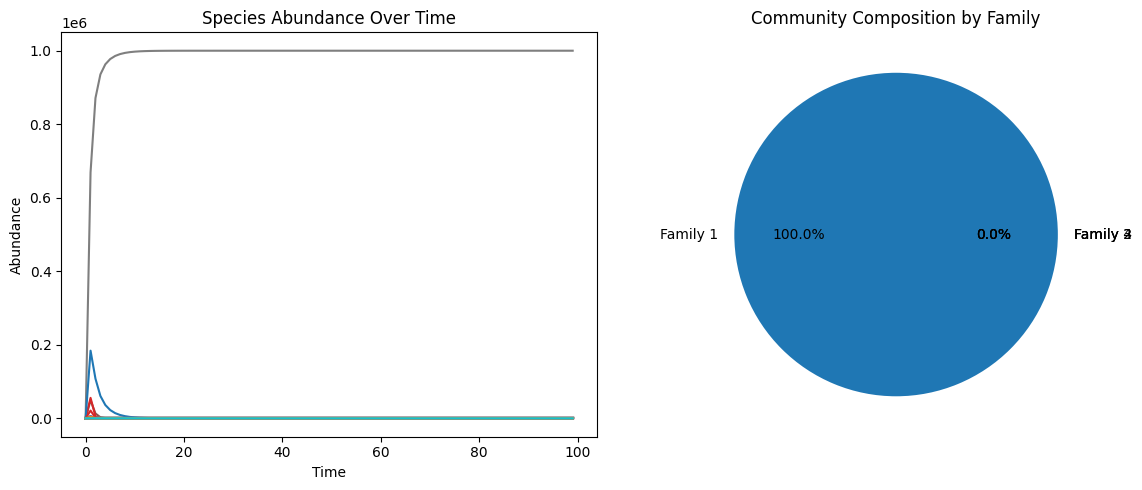

In [29]:
# Plot species abundance over time
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(result['species'])
axs[0].set_title("Species Abundance Over Time")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Abundance")

# Plot coarse-grained community structure
final_abundance = result['communityStruct']
x = coarse_grain_community_structure(final_abundance, group_labels, numGroups)
x[x < 1e-10] = 0
axs[1].pie(x + 1e-20, labels=[f"Family {i+1}" for i in range(numGroups)], autopct='%1.1f%%')
axs[1].set_title("Community Composition by Family")

plt.tight_layout()
plt.show()

In [30]:
diversity = alpha_diversity(result['communityStruct'])
print(diversity['Shannon'])


0.0


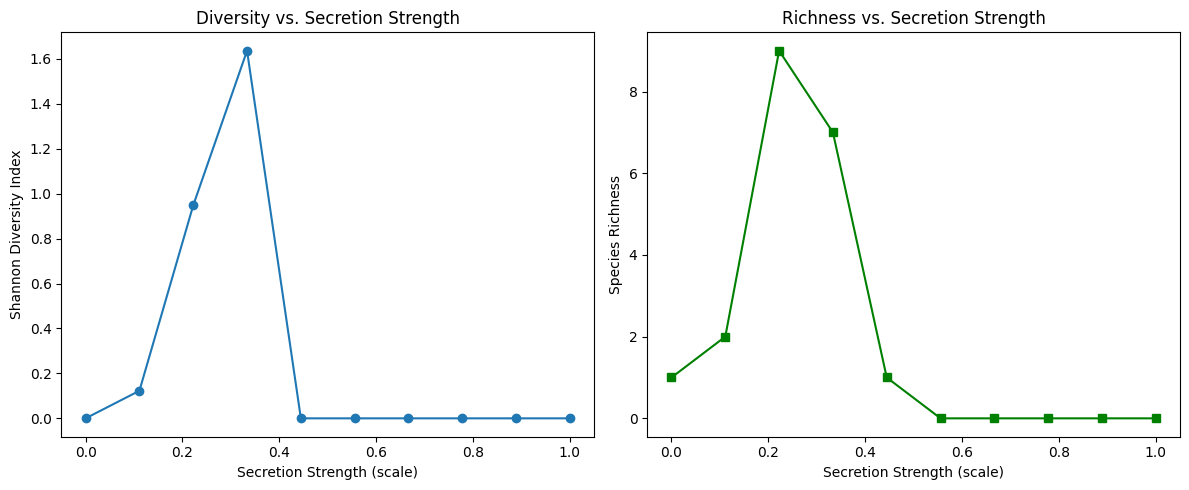

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Sweep settings
secretion_strengths = np.linspace(0.0, 1, 10)  # from no secretion to full secretion
shannon_list = []
richness_list = []

# Fixed model parameters
Total_Number_Of_Species = 1000
numSpecies = 100
numGroups = 5
numResources = 5
Total = 100
specialist = 0.5
specialistVar = 0.01
resourceIdx = 1

# Begin sweep
for scale in secretion_strengths:
    # Generate secretion matrix D
    D = get_metabolism(numResources, 'rand', scale)

    # Generate priors and consumer matrix
    priors = [get_consumer_priors(100, i, specialist, specialistVar, numResources).T for i in range(numGroups)]
    out, _ = make_phylo_consumers(Total_Number_Of_Species, numResources, numGroups, priors, Total, True)

    # Randomly select a community
    k = np.random.choice(Total_Number_Of_Species, numSpecies, replace=False)
    C_sampled = out['C'][k, :]
    group_sampled = np.array(out['group'])[k]

    # Initialize model parameters
    params = mcrm_params(resourceIdx, numSpecies, C_sampled, D, 'eye', W_mode='shared' )
    
    # Run CRM simulation
    result = run_mcrm(params)
    final_abundances = result['communityStruct']
    
    diversity = alpha_diversity(result['communityStruct'])
    shannon = diversity['Shannon']
    richness = diversity['Richness']
    
    # Store metrics
    shannon_list.append(shannon)
    richness_list.append(richness)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(secretion_strengths, shannon_list, marker='o')
ax[0].set_xlabel('Secretion Strength (scale)')
ax[0].set_ylabel('Shannon Diversity Index')
ax[0].set_title('Diversity vs. Secretion Strength')

ax[1].plot(secretion_strengths, richness_list, marker='s', color='green')
ax[1].set_xlabel('Secretion Strength (scale)')
ax[1].set_ylabel('Species Richness')
ax[1].set_title('Richness vs. Secretion Strength')

plt.tight_layout()
plt.show()

/var/folders/70/4lfklr4n6c5c6t79k1pf_3xh0000gr/T/ipykernel_91354/219719146.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


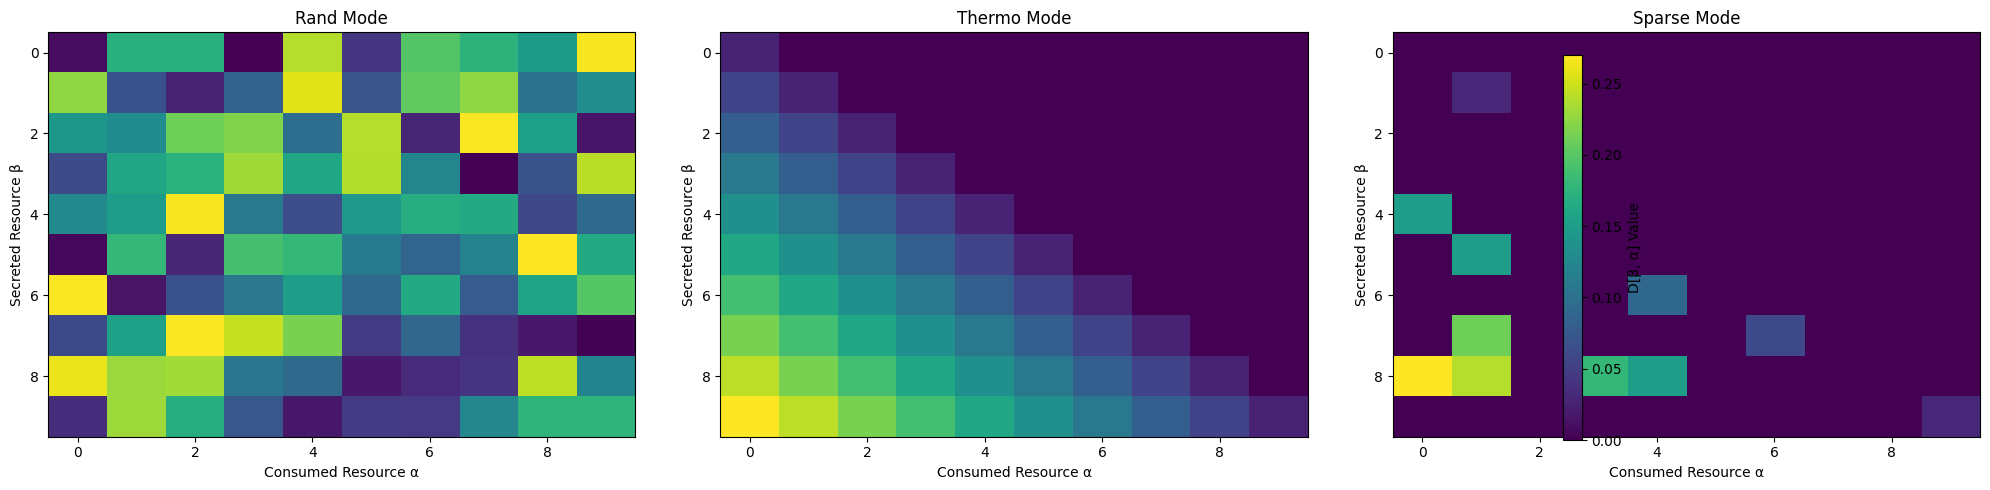

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def get_metabolism(num_resources, flag='rand', p=0.1):
    if flag in ['thermo', 'sparse']:
        w = np.arange(num_resources, 0, -1)
        d = np.flip(w) / num_resources
        D = np.array([np.concatenate([np.zeros(i), d[:num_resources - i]]) for i in range(num_resources)])
        D = 0.3 * D.T
        if flag == 'sparse':
            M = np.random.binomial(1, p, (num_resources, num_resources))
            D *= M
    elif flag == 'rand':
        D = np.random.rand(num_resources, num_resources) * p
    else:
        raise ValueError("Unknown flag type.")
    return D

# Visualize for different flags
num_resources = 10
modes = ['rand', 'thermo', 'sparse']

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for ax, mode in zip(axes, modes):
    D = get_metabolism(num_resources, flag=mode, p=0.3)
    im = ax.imshow(D, cmap='viridis', aspect='auto')
    ax.set_title(f'{mode.capitalize()} Mode')
    ax.set_xlabel('Consumed Resource α')
    ax.set_ylabel('Secreted Resource β')
    
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=1, label='D[β, α] Value', pad=0.2)
plt.tight_layout()
plt.show()

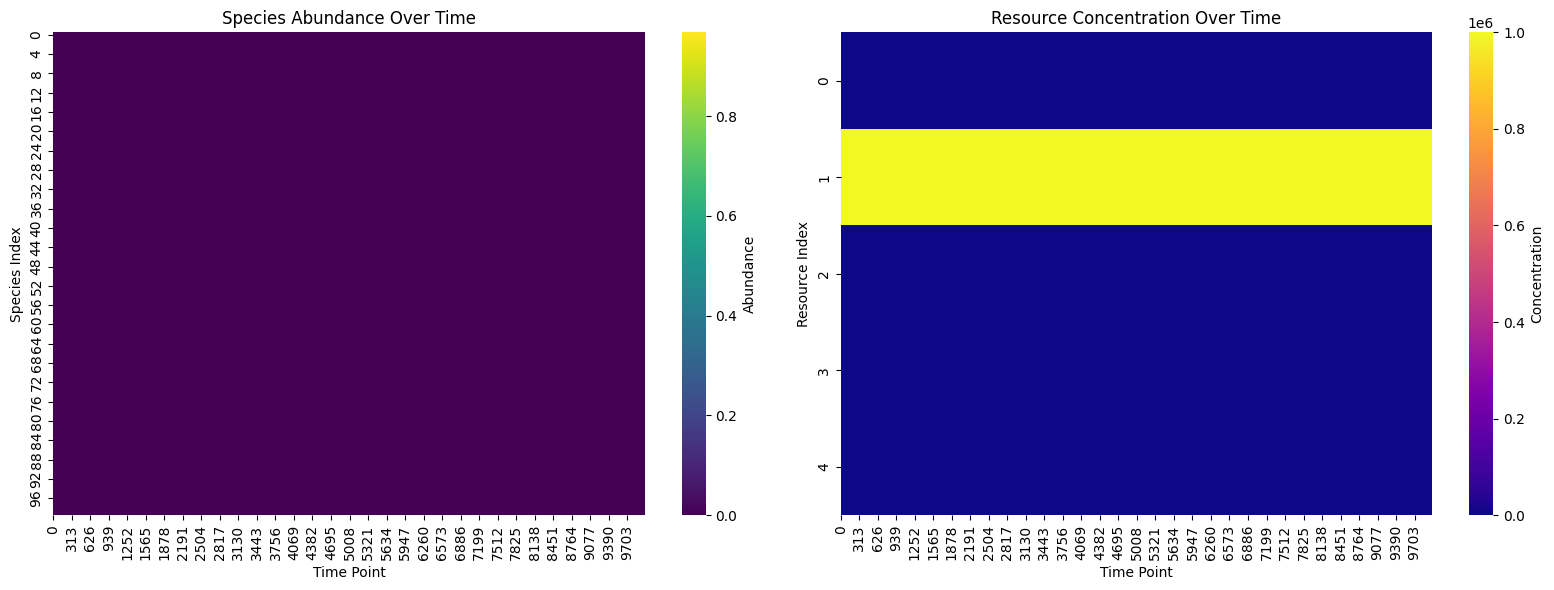

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

species_data = result['species']
resource_data = result['resources']

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Species abundance heatmap
sns.heatmap(species_data.T, ax=axs[0], cmap='viridis', cbar_kws={'label': 'Abundance'})
axs[0].set_title('Species Abundance Over Time')
axs[0].set_xlabel('Time Point')
axs[0].set_ylabel('Species Index')

# Resource concentration heatmap
sns.heatmap(resource_data.T, ax=axs[1], cmap='plasma', cbar_kws={'label': 'Concentration'})
axs[1].set_title('Resource Concentration Over Time')
axs[1].set_xlabel('Time Point')
axs[1].set_ylabel('Resource Index')

plt.tight_layout()
plt.show()

In [36]:
num_resources = 3         # 3 different resources
num_groups = 4            # 4 metabolic families
total_species = 1000      # species in the total pool
subset_size = 50          # community size
replicates = 20
Total = 100               # Dirichlet prior for family generation
numResource = 10
specialist = 0.5
specialistVariation = 0.01

# Generate global consumer pool from 4 families
priors = [get_consumer_priors(100, r, specialist, specialistVariation, numResource)
          for r in range(num_groups)]
out, _ = make_phylo_consumers(total_species, numResource, num_groups, priors, Total, non_normal=True)

results = []

for resource_idx in range(num_resources):  # Resource 0, 1, 2
    for _ in range(replicates):
        # Sample a community
        k = np.random.choice(total_species, subset_size, replace=False)
        C_sample = out['C'][k]
        group_labels = out['group'][k]
        
        # Simulate growth on resource `resource_idx`
        D = get_metabolism(numResource, 'rand', 1/numResource)
        params = mcrm_params(resource_idx, subset_size, C_sample, D, qual='eye')
        result = run_mcrm(params)
        
        # Save result with group labels and supplied resource
        results.append({
            'species_abundance': result['communityStruct'],
            'resource_abundance': result['environmentalStruct'],
            'group_labels': group_labels,
            'resource_idx': resource_idx,
            'uptake_capacity': np.sum(C_sample @ result['environmentalStruct']),
            'C_sample': C_sample
        })

In [37]:
for r in results:
    surviving = r['species_abundance'] > 1e-4
    growth_support = np.sum(r['C_sample'][surviving], axis=1)
    print("Min support for surviving species:", np.min(growth_support))

Min support for surviving species: 0.9874508720433558
Min support for surviving species: 0.9892197036613611
Min support for surviving species: 0.9939157873952436
Min support for surviving species: 0.9947947128498352
Min support for surviving species: 0.9885621291793341
Min support for surviving species: 0.9947947128498352
Min support for surviving species: 0.9892197036613611
Min support for surviving species: 0.9859422462869718
Min support for surviving species: 0.9965131002086441
Min support for surviving species: 0.998660456270714
Min support for surviving species: 0.9892197036613611
Min support for surviving species: 0.993433220827823
Min support for surviving species: 0.9907318001459573
Min support for surviving species: 0.9964273376050792
Min support for surviving species: 0.9981567584215096
Min support for surviving species: 0.9779062079289597
Min support for surviving species: 0.9934415430650021
Min support for surviving species: 0.996020757375773
Min support for surviving speci

/var/folders/70/4lfklr4n6c5c6t79k1pf_3xh0000gr/T/ipykernel_91354/2073038519.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


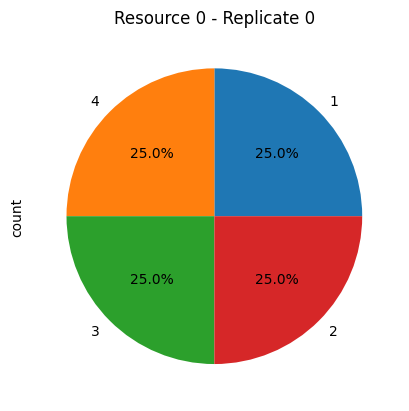

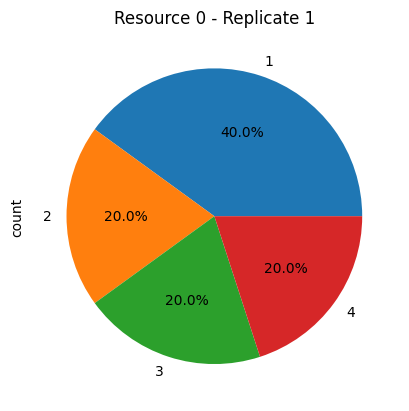

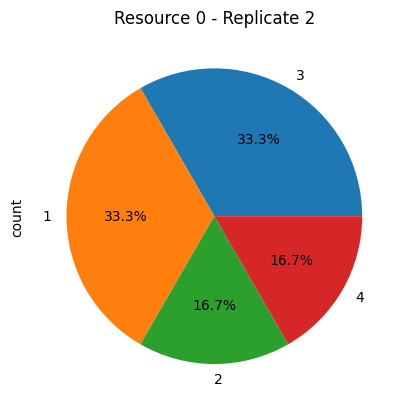

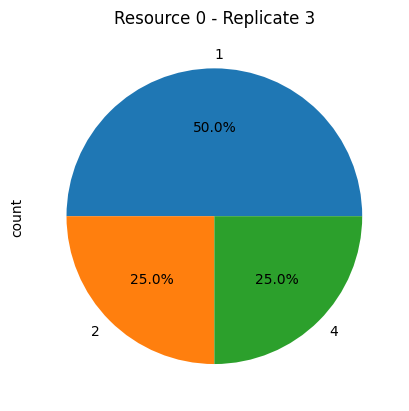

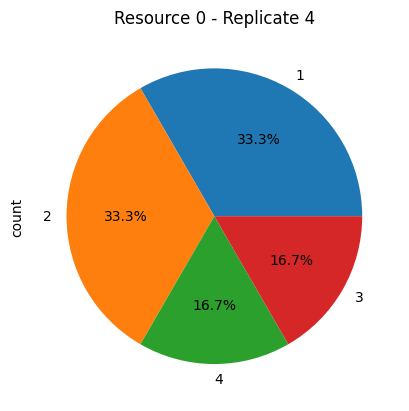

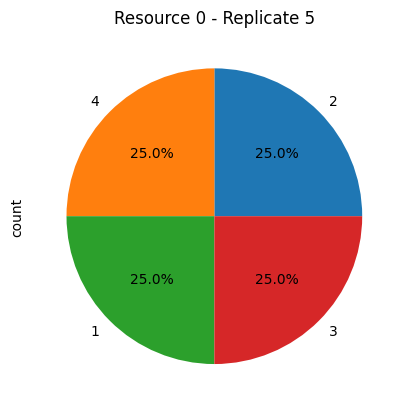

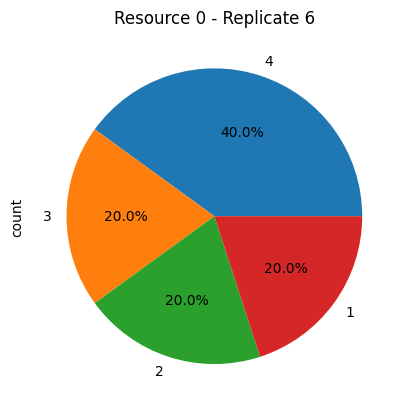

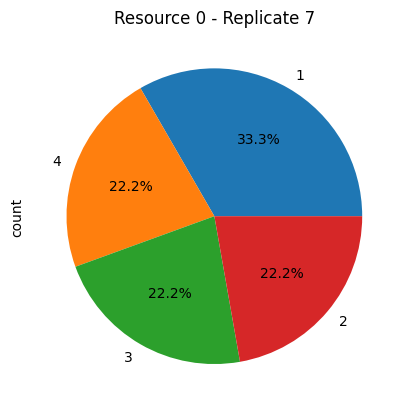

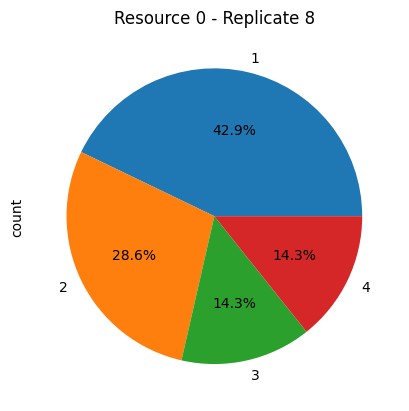

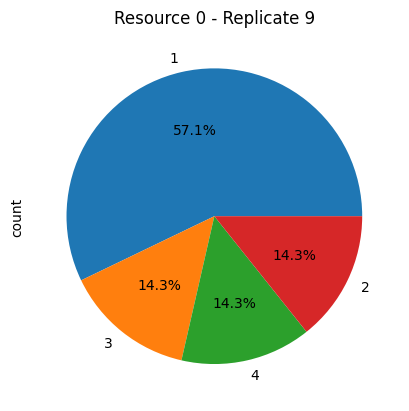

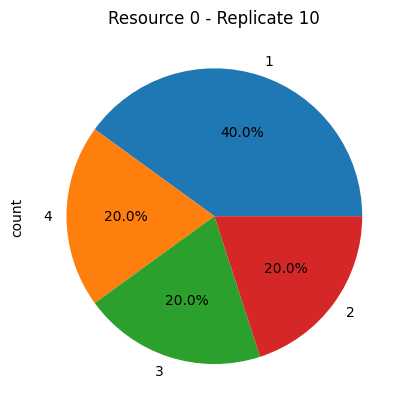

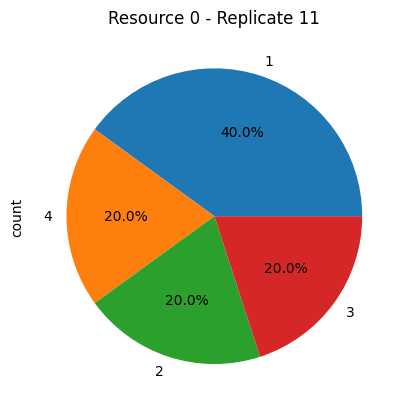

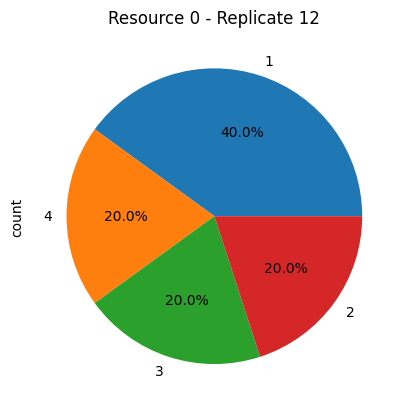

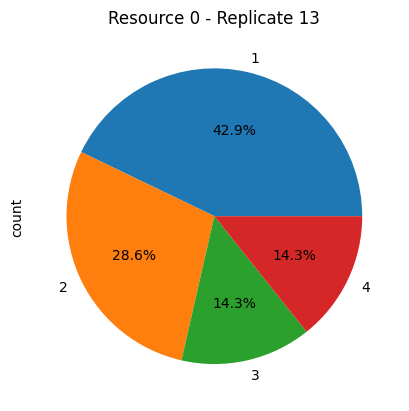

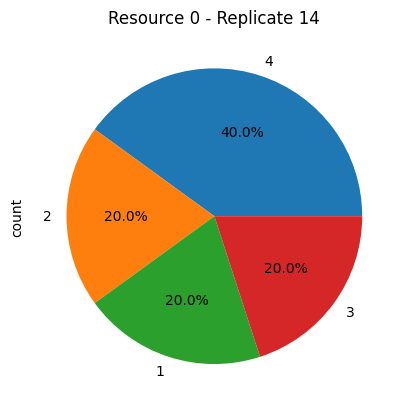

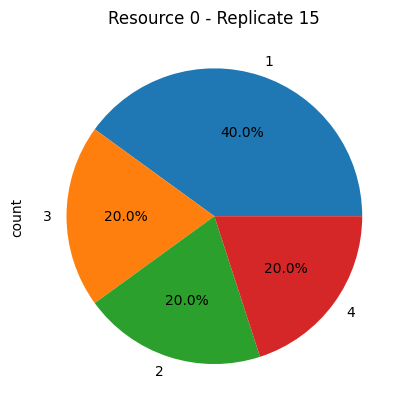

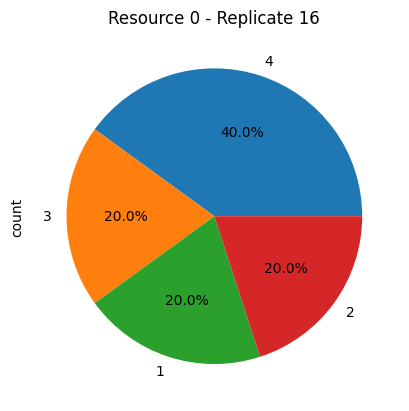

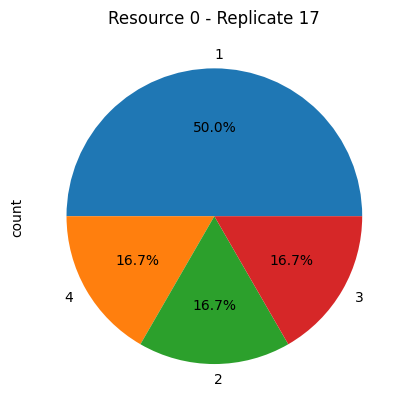

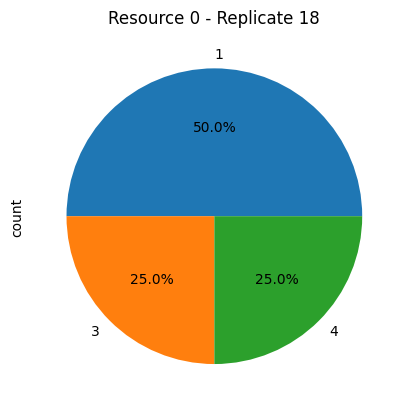

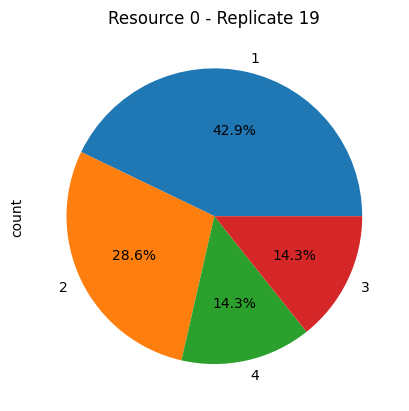

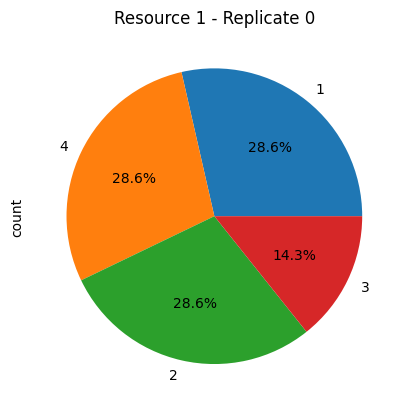

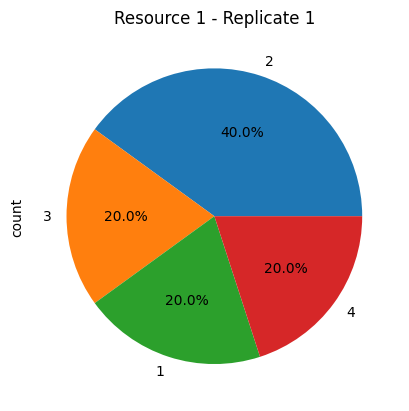

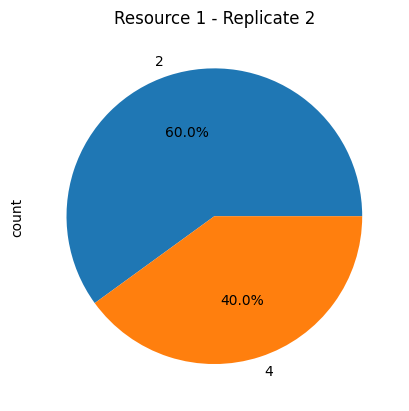

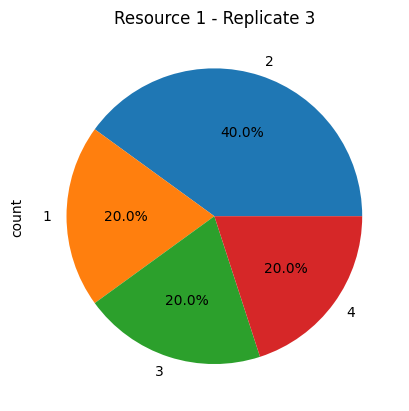

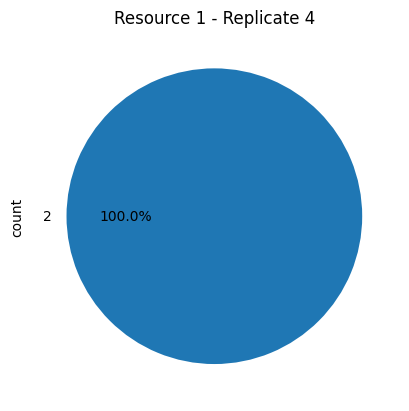

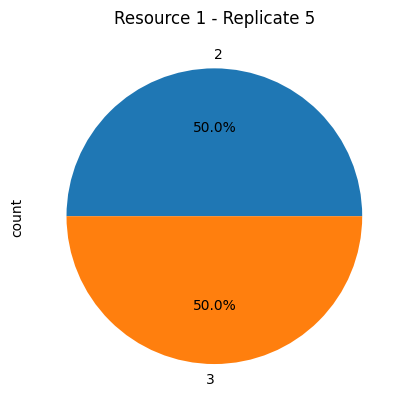

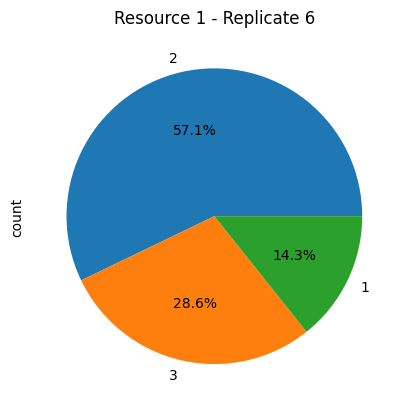

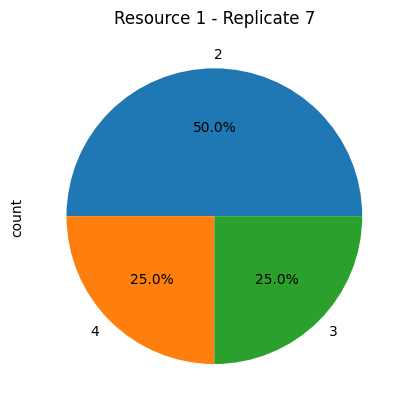

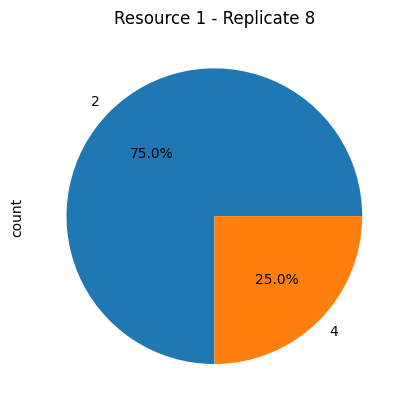

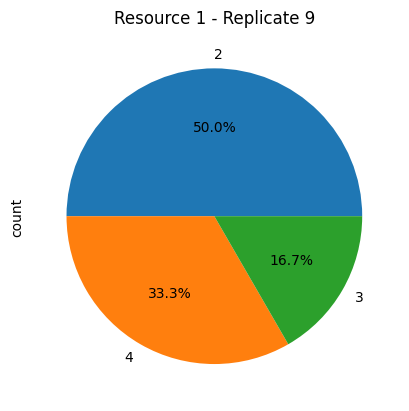

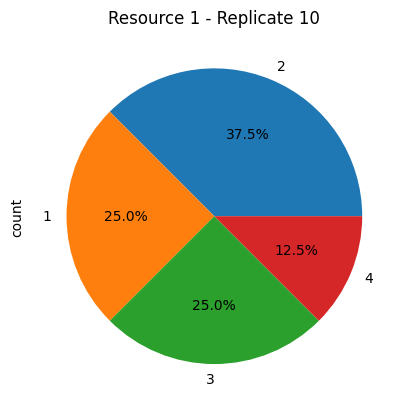

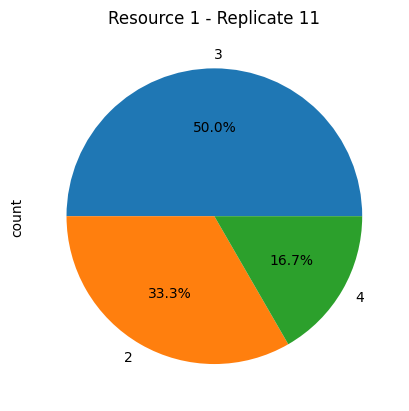

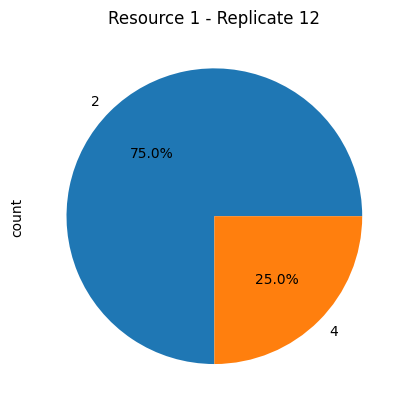

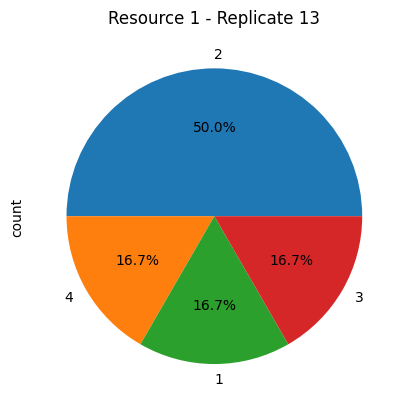

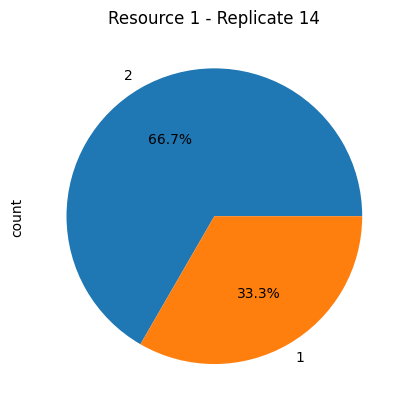

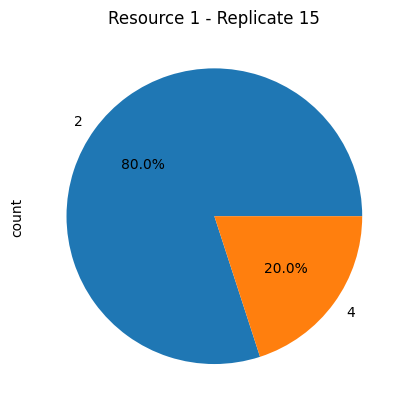

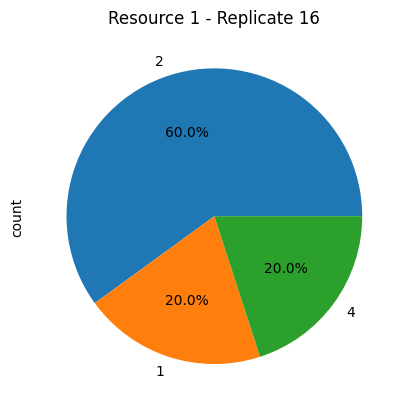

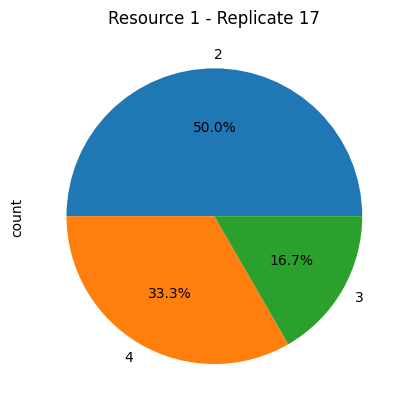

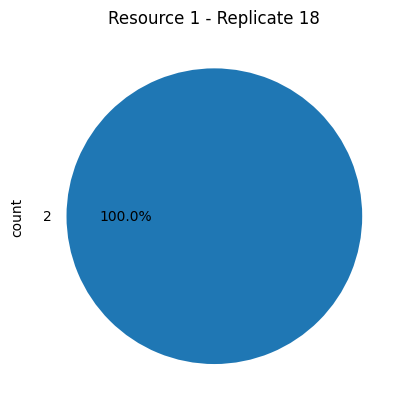

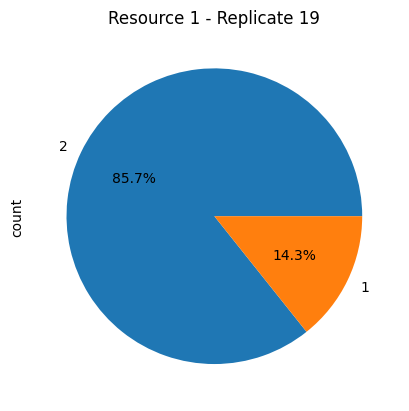

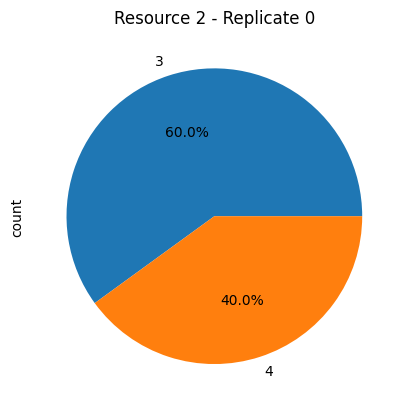

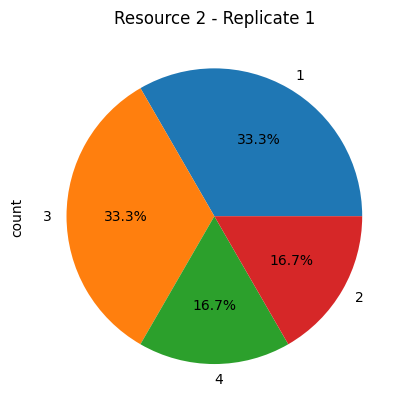

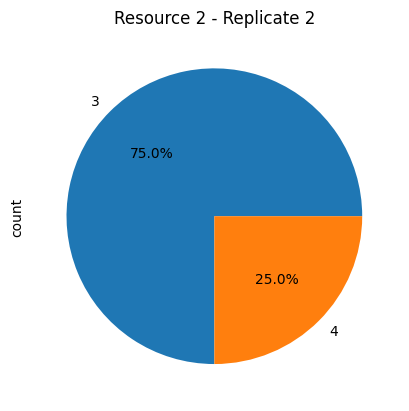

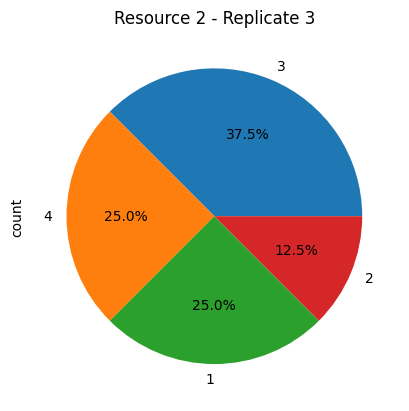

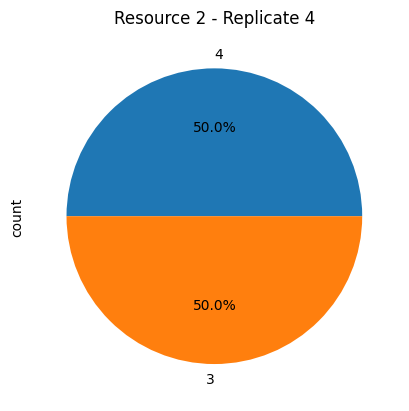

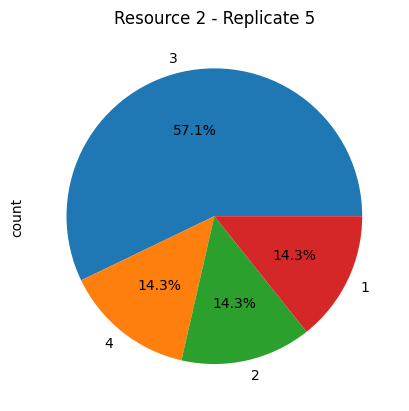

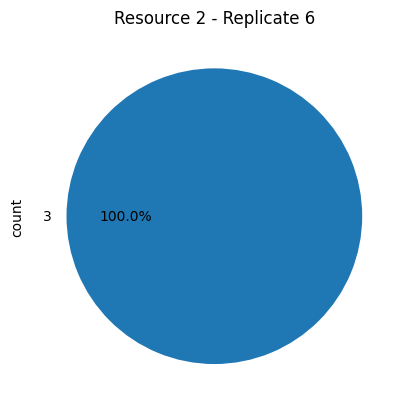

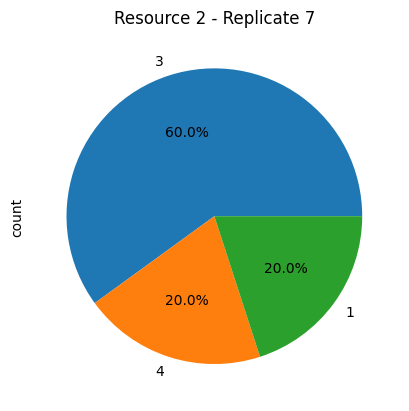

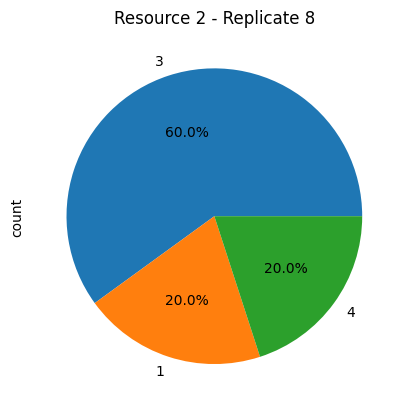

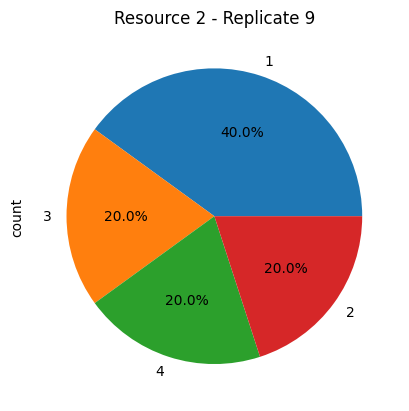

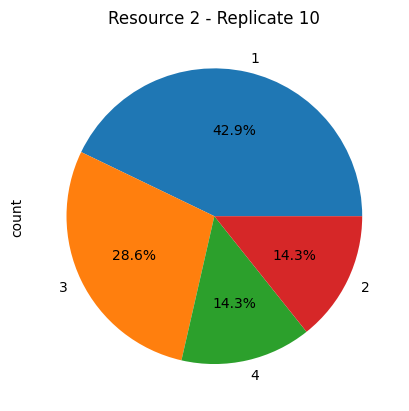

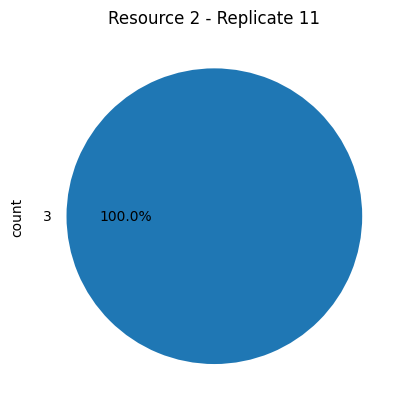

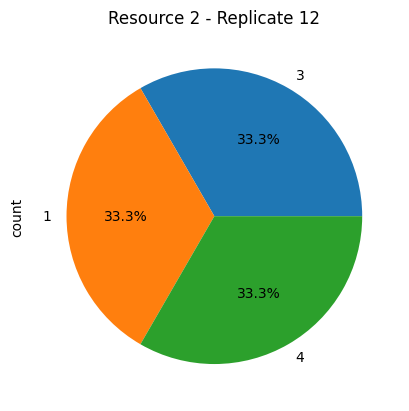

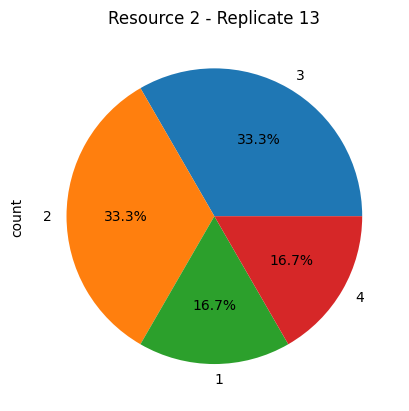

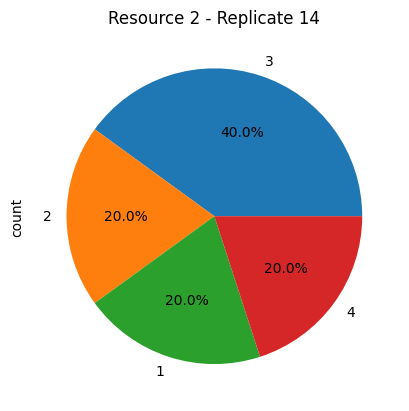

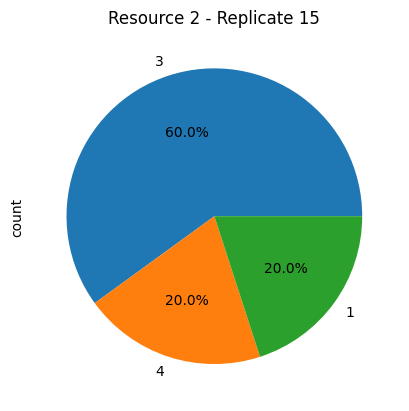

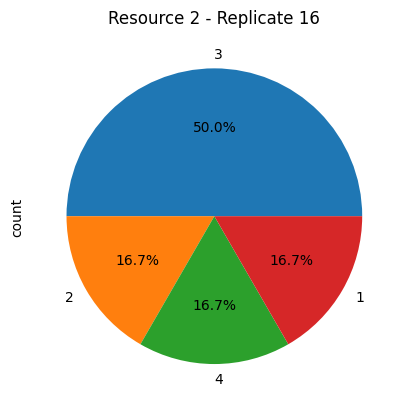

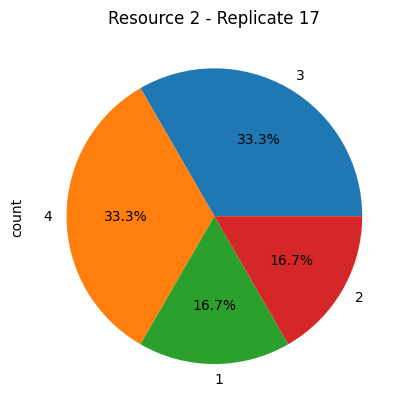

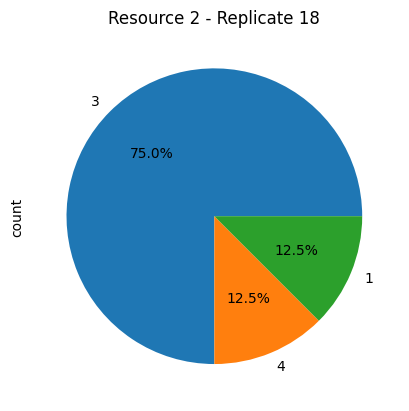

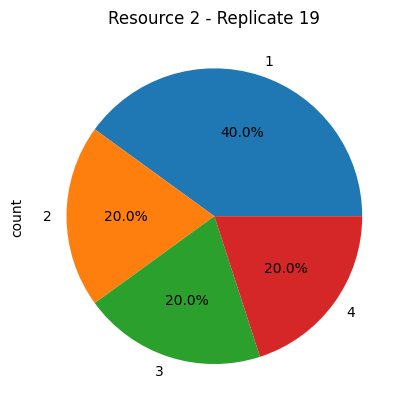

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

for i, r in enumerate(results):
    surviving = r['species_abundance'] > 1e-4
    family_counts = pd.Series(r['group_labels'][surviving]).value_counts()
    plt.figure()
    family_counts.plot.pie(autopct='%1.1f%%')
    plt.title(f"Resource {r['resource_idx']} - Replicate {i % replicates}")

Text(0.5, 1.0, 'Functional Convergence by Supplied Resource')

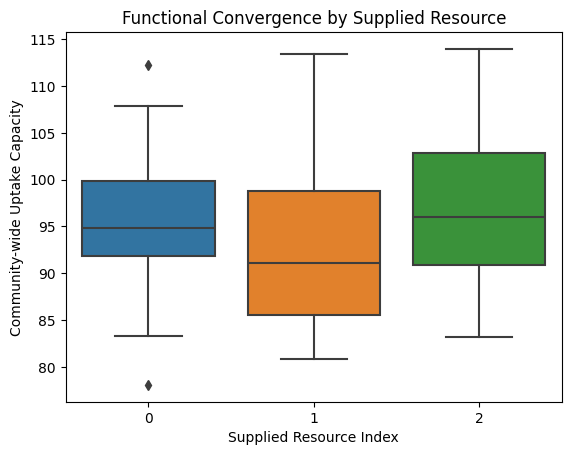

In [39]:
df = pd.DataFrame(results)
sns.boxplot(data=df, x='resource_idx', y='uptake_capacity')
plt.xlabel("Supplied Resource Index")
plt.ylabel("Community-wide Uptake Capacity")
plt.title("Functional Convergence by Supplied Resource")

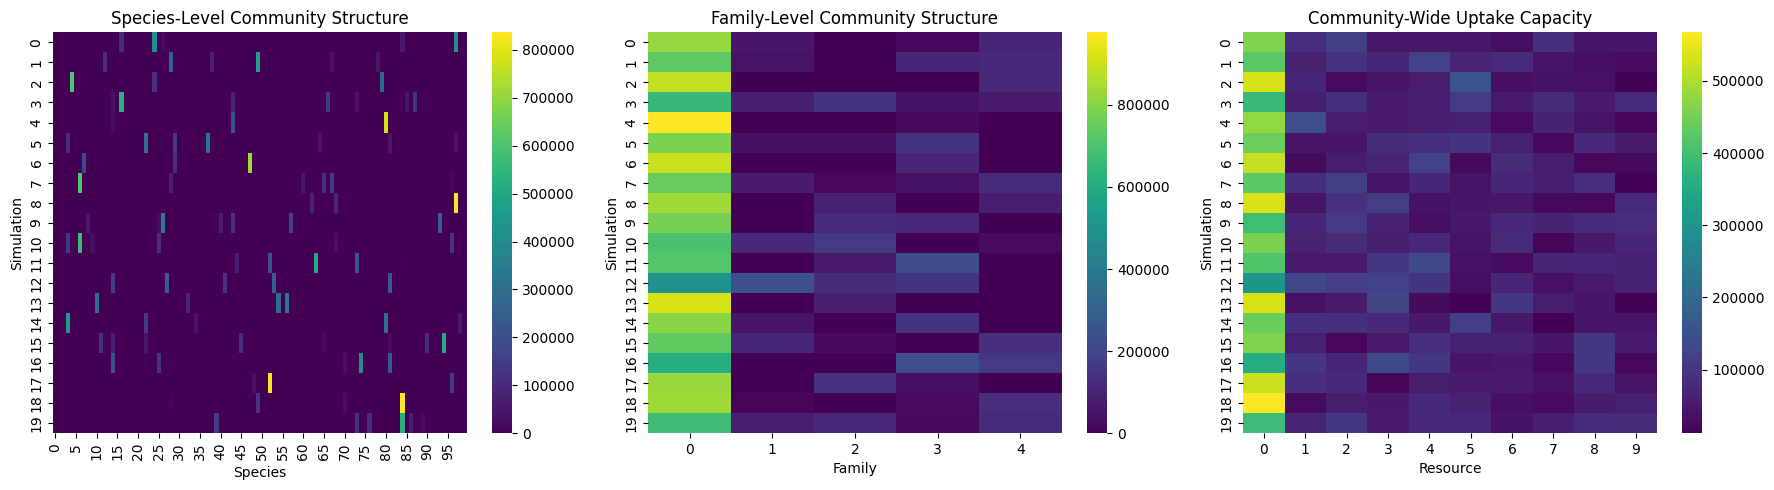

In [40]:
# Corrected function for resource index clamping
def get_consumer_priors_fixed(T, r, specialist, specialistVar, num_resources):
    R = np.random.rand(num_resources)
    r = r % num_resources  # Ensure r is within bounds
    f = np.clip(np.random.normal(specialist, specialistVar), 0, 1)
    other = [i for i in range(num_resources) if i != r]
    R[other] = (T - f*T) * np.random.dirichlet(np.ones(len(other)))
    R[r] = f*T
    return R

# Replace function call with the fixed one
family_structures = []
species_structures = []
uptake_capacities = []

for _ in range(20):
    D = get_metabolism(numResource, 'rand', 1/numResource)
    priors = [get_consumer_priors_fixed(100, x, specialist, specialistVariation, numResource)
              for x in range(numGroups)]
    out, _ = make_phylo_consumers(Total_Number_Of_Species, numResource, numGroups, priors, Total, non_normal=True)
    k = np.random.choice(Total_Number_Of_Species, numSpecies, replace=False)
    C_sample = out['C'][k]
    group_labels = out['group'][k]

    params = mcrm_params(
        resource_idx=0,
        num_species=numSpecies,
        C=C_sample,
        D=D,
        qual='eye',
        W_mode='shared'
    )

    result = run_mcrm(params, num_points=100)
    surviving_species = result['communityStruct'] > 1e-4
    species_structures.append(result['communityStruct'])
    family_structure = coarse_grain_community_structure(result['communityStruct'], group_labels, numGroups)
    family_structures.append(family_structure)
    uptake_capacity = C_sample.T @ result['communityStruct']
    uptake_capacities.append(uptake_capacity)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(np.array(species_structures), ax=axes[0], cmap='viridis')
axes[0].set_title('Species-Level Community Structure')
axes[0].set_xlabel('Species')
axes[0].set_ylabel('Simulation')

sns.heatmap(np.array(family_structures), ax=axes[1], cmap='viridis')
axes[1].set_title('Family-Level Community Structure')
axes[1].set_xlabel('Family')
axes[1].set_ylabel('Simulation')

sns.heatmap(np.array(uptake_capacities), ax=axes[2], cmap='viridis')
axes[2].set_title('Community-Wide Uptake Capacity')
axes[2].set_xlabel('Resource')
axes[2].set_ylabel('Simulation')

plt.tight_layout()
plt.show()